<a href="https://colab.research.google.com/github/nidanafila/Image-Classification-Model-Deployment/blob/main/Image_Classification_Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Nida Nafila

E-mail : naifanida5858@gmail.com

In [1]:
#install data dari kaggle
!pip install -q kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

#download dataset
!kaggle datasets download -d viratkothari/animal10

!mkdir animals
!unzip -qq animal10.zip -d animals
!ls animals

Saving kaggle.json to kaggle.json
kaggle.json
100% 585M/585M [00:03<00:00, 195MB/s]
100% 585M/585M [00:03<00:00, 181MB/s]
Animals-10


In [2]:
import shutil
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
print(os.listdir("../content"))
dataDirectory= "../content/animals/Animals-10"
print(os.listdir(dataDirectory))

['.config', 'animal10.zip', 'animals', 'kaggle.json', 'sample_data']
['butterfly', 'spider', 'dog', 'sheep', 'cow', 'elephant', 'horse', 'squirrel', 'cat', 'chicken']


In [4]:
ignore_animals = ['squirrel', 'sheep', 'cat', 'cow', 'dog', 'elephant', 'horse']

animals = os.path.join('/content/animals/Animals-10')
for x in ignore_animals:
  path = os.path.join(animals, x)
  shutil.rmtree(path)

In [5]:
total = 0
list_animals = os.listdir(animals)

for x in list_animals:
  dir = os.path.join(animals, x)
  y = len(os.listdir(dir))
  print(x+':', y)
  total = total + y

  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nTotal Gambar :', total)

butterfly: 2112
- (295, 211)
- (640, 426)
- (300, 224)
- (300, 300)
---------------
spider: 4821
- (300, 236)
- (258, 300)
- (640, 426)
- (300, 291)
---------------
chicken: 3098
- (248, 251)
- (300, 300)
- (300, 267)
- (300, 201)
---------------

Total Gambar : 10031


In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [7]:
batch_size = 40

data_train = train_datagen.flow_from_directory(
    animals,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

data_val = train_datagen.flow_from_directory(
    animals,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 8026 images belonging to 3 classes.
Found 2005 images belonging to 3 classes.


In [8]:
tf.device('/device:GPU:0')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85 and logs.get('val_accuracy')>0.85):
      print("\nAkurasi terlampaui!")
      self.model.stop_training = True

callbacks = myCallback()

In [10]:
history = model.fit(data_train,
                    epochs = 40,
                    steps_per_epoch = 40,
                    validation_data = data_val,
                    validation_steps = 40,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/40
40/40 [==============================] - 34s 532ms/step - loss: 1.0454 - accuracy: 0.4869 - val_loss: 0.9688 - val_accuracy: 0.5219
Epoch 2/40
40/40 [==============================] - 21s 536ms/step - loss: 0.9446 - accuracy: 0.5246 - val_loss: 0.8721 - val_accuracy: 0.5913
Epoch 3/40
40/40 [==============================] - 20s 501ms/step - loss: 0.8517 - accuracy: 0.6040 - val_loss: 0.8503 - val_accuracy: 0.6050
Epoch 4/40
40/40 [==============================] - 22s 563ms/step - loss: 0.8137 - accuracy: 0.6513 - val_loss: 0.8004 - val_accuracy: 0.6475
Epoch 5/40
40/40 [==============================] - 21s 528ms/step - loss: 0.7563 - accuracy: 0.6869 - val_loss: 0.7261 - val_accuracy: 0.7056
Epoch 6/40
40/40 [==============================] - 20s 499ms/step - loss: 0.6674 - accuracy: 0.7276 - val_loss: 0.6641 - val_accuracy: 0.7525
Epoch 7/40
40/40 [==============================] - 20s 517ms/step - loss: 0.6208 - accuracy: 0.7556 - val_loss: 0.6275 - val_accuracy: 0.7544

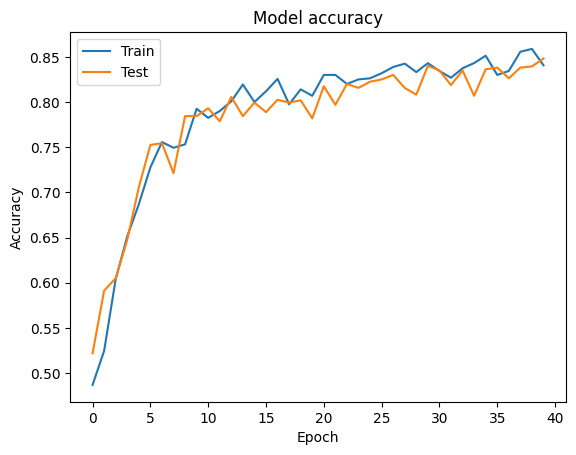

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

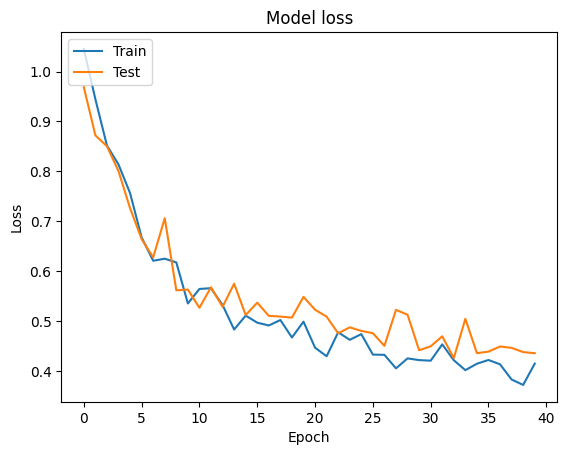

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
import pathlib
export_dir = '/content/'
tf.saved_model.save(model, export_dir)
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

tf.saved_model.save(model, '/content/')